In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [4]:
import tensorflow as tf
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

2.7.0


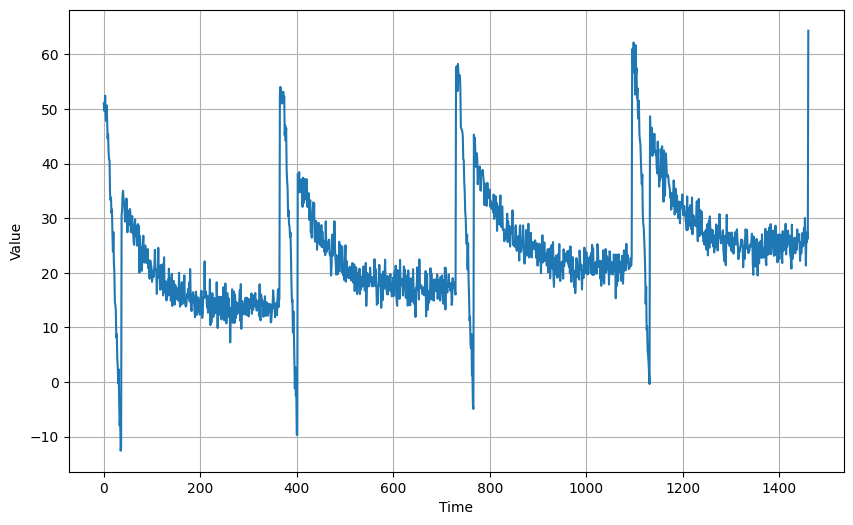

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# EXPECTED OUTPUT
# Chart as in the screencast. First should have 5 distinctive 'peaks'

Now that we have the time series, let's split it so we can start forecasting

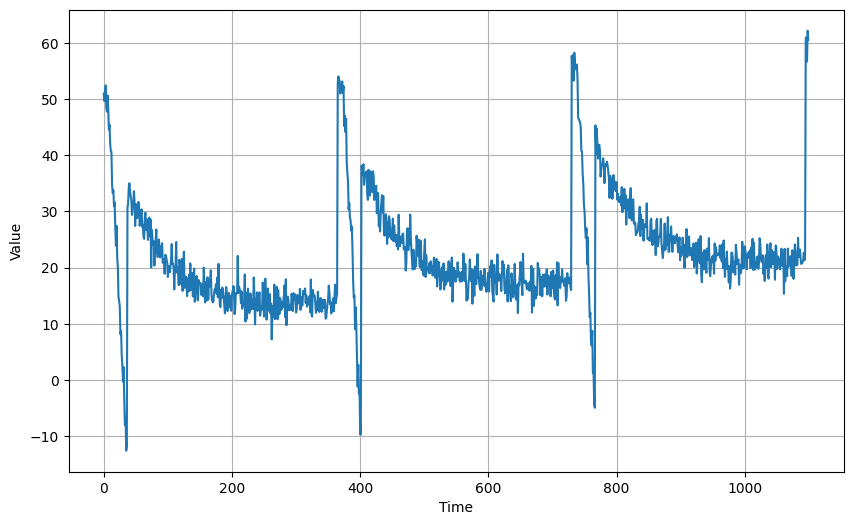

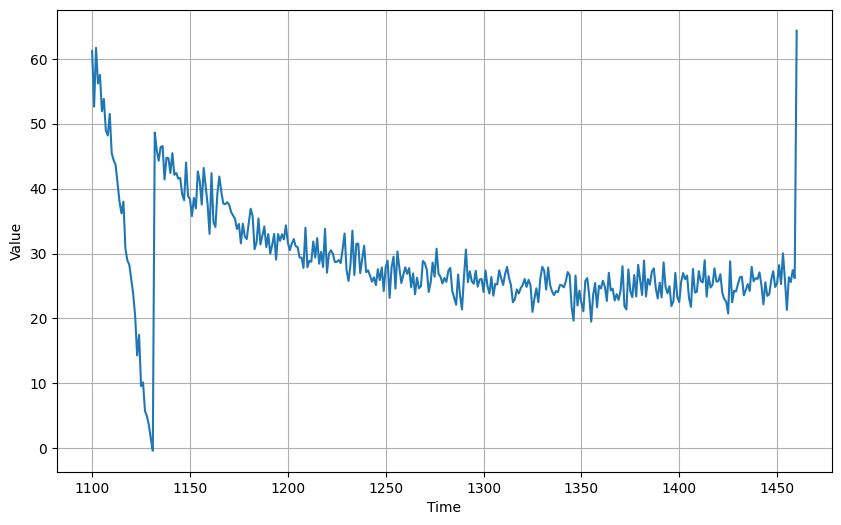

In [6]:
split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# EXPECTED OUTPUT
# Chart WITH 4 PEAKS between 50 and 65 and 3 troughs between -12 and 0
# Chart with 2 Peaks, first at slightly above 60, last at a little more than that, should also have a single trough at about 0

# Naive Forecast

In [7]:
naive_forecast = series[split_time-1:-1] 

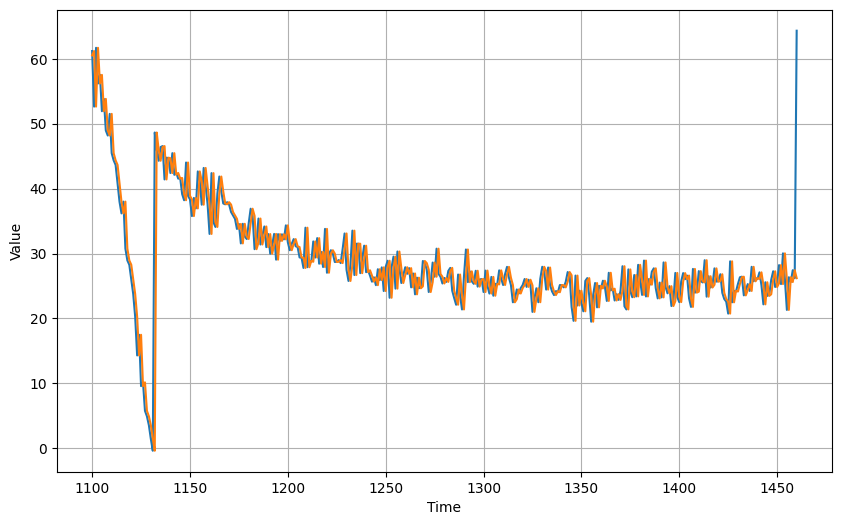

In [8]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)
plt.show() 
# Expected output: Chart similar to above, but with forecast overlay

Let's zoom in on the start of the validation period:

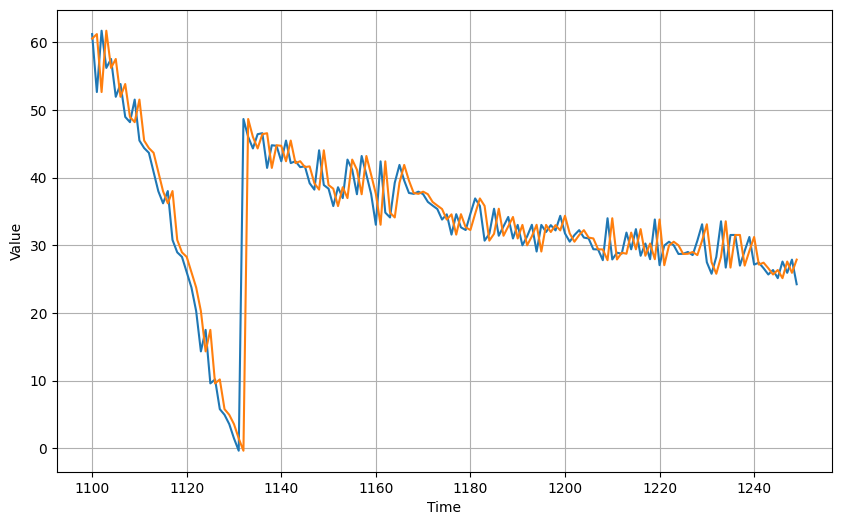

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=0, end=150)
plt.show() 

# EXPECTED - Chart with X-Axis from 1100-1250 and Y Axes with series value and projections. Projections should be time stepped 1 unit 'after' series

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [24]:
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())
# Expected Output
# 19.578304
# 2.6011968

19.578304
2.6011972


That's our baseline, now let's try a moving average:

In [25]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
        If window_size=1, then this is equivalent to naive forecast"""
    ### START CODE HERE  
    moving_avg = np.array([series[i:i+window_size].mean() for i in range(len(series) - window_size)])
    return moving_avg
    
    ### END CODE HERE

361
361


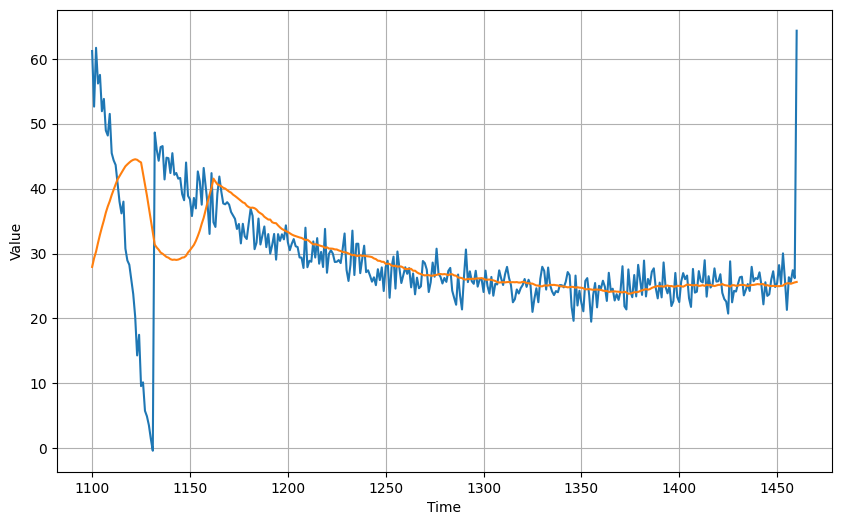

In [34]:
window_size = 30 
moving_avg = moving_average_forecast(series, window_size)[split_time - window_size:]

print(len(moving_avg))
print(len(time_valid))

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
plt.show()
    
# EXPECTED OUTPUT
# CHart with time series from 1100->1450+ on X
# Time series plotted
# Moving average plotted over it

In [35]:
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())
# EXPECTED OUTPUT
# 65.786224
# 4.3040023

65.786224
4.3040023


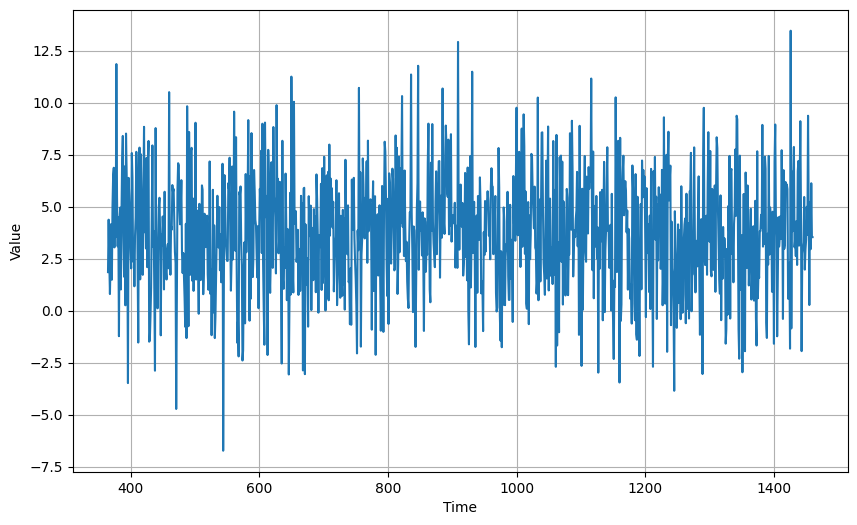

In [30]:
diff_series = series[365:] - series[0:-365]
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()
    
# EXPECETED OUTPUT: CHart with diffs

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

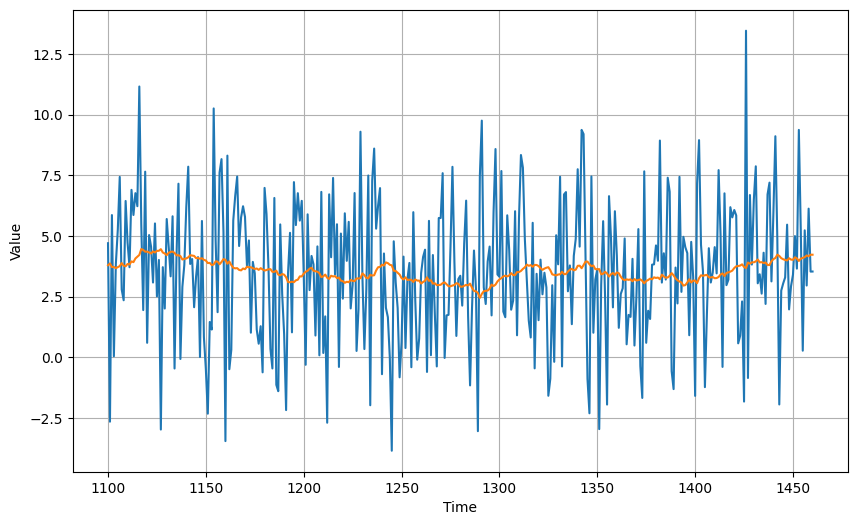

In [43]:
window_size = 50 
diff_moving_avg = moving_average_forecast(diff_series, window_size)[split_time - 365 - window_size:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()
            
# Expected output. Diff chart from 1100->1450 +
# Overlaid with moving average

Now let's bring back the trend and seasonality by adding the past values from t – 365:

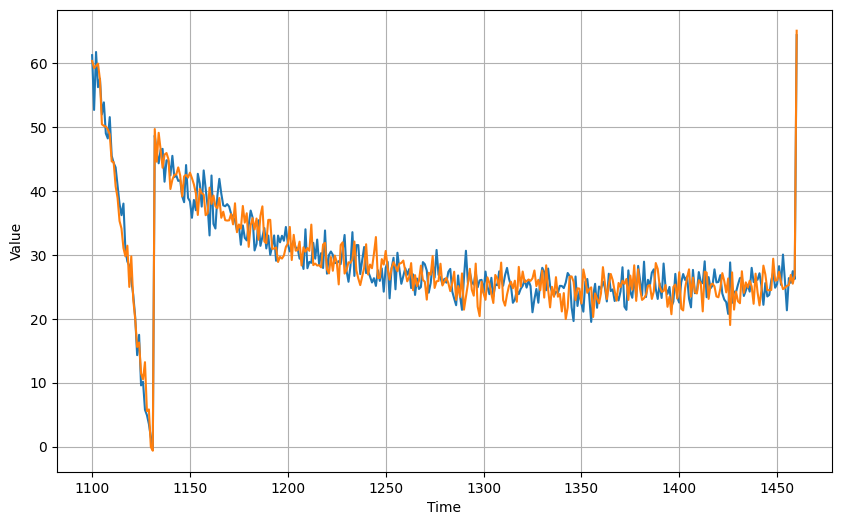

In [49]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()
# Expected output: Chart from 1100->1450+ on X. Same chart as earlier for time series, but projection overlaid looks close in value to it

In [90]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())
# EXPECTED OUTPUT
# 8.498155
# 2.327179

8.498155
2.327179


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

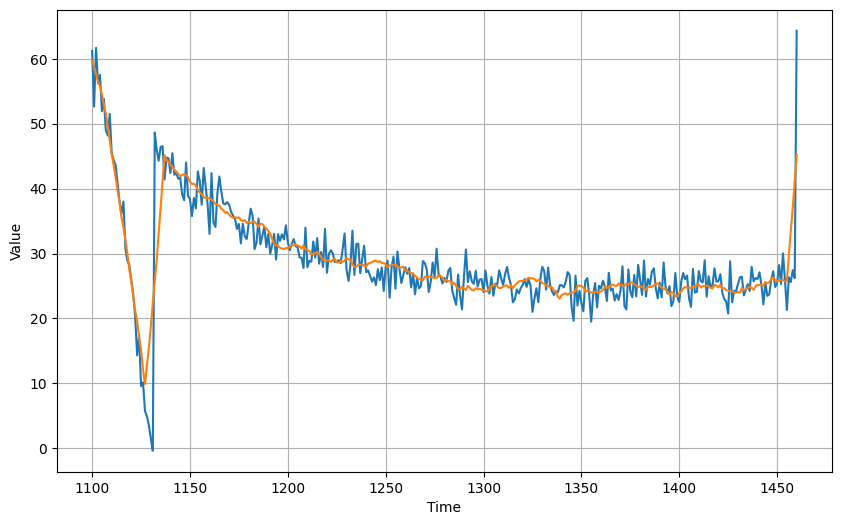

In [93]:
window_size_1 = 10
half_window_size_1 = 5

#diff_moving_avg_plus_smooth_past = moving_average_forecast(series, window_size_1)[split_time - 365 - window_size_1 :-365 ] 
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 360- half_window_size_1 - window_size_1:-365+half_window_size_1], window_size_1) 
diff_moving_avg_plus_smooth_past = diff_moving_avg_plus_smooth_past + diff_moving_avg

plt.figure(figsize=(10, 6)) 
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()
            
# # EXPECTED OUTPUT:
# # Similar chart to above, but the overlaid projections are much smoother

In [ ]:
MSE虽然有些提高，但是总体更加平滑了，也就说，更加robust更加好。

In [94]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
# EXPECTED OUTPUT
# 12.527958
# 2.2034433

12.527956
2.2034435


In [95]:
import tensorflow as tf

In [105]:
dataset = tf.data.Dataset.range(10) 
for data in dataset:
    print(data.numpy(), end=' ')
print()

0 1 2 3 4 5 6 7 8 9 


In [108]:
dataset = tf.data.Dataset.range(10) 
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
    for data in window_dataset:
        print(data.numpy(), end=' ')
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [109]:
dataset = tf.data.Dataset.range(10) 
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
    for data in window_dataset:
        print(data.numpy(), end=' ')
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [118]:
dataset = tf.data.Dataset.range(10) 
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.map(lambda window_dataset:  window_dataset.batch(5))

for window_dataset in dataset:
    for data in window_dataset:
        print(data.numpy(), end=' ')
    print()

[0 1 2 3 4] 
[1 2 3 4 5] 
[2 3 4 5 6] 
[3 4 5 6 7] 
[4 5 6 7 8] 
[5 6 7 8 9] 


In [121]:
dataset = tf.data.Dataset.range(10) 
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset:  window_dataset.batch(5))

for data in dataset:
    print(data.numpy()) 

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [124]:
dataset = tf.data.Dataset.range(10) 
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window:  window.batch(5))
dataset = dataset.map(lambda window:  (window[:-1], window[-1:]))

for x, y in dataset:
    print(x.numpy(), y.numpy()) 

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [126]:
dataset = tf.data.Dataset.range(10)  
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window:  window.batch(5))
dataset = dataset.map(lambda window:  (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10) 

for x, y in dataset:
    print(x.numpy(), y.numpy()) 

[5 6 7 8] [9]
[4 5 6 7] [8]
[0 1 2 3] [4]
[3 4 5 6] [7]
[1 2 3 4] [5]
[2 3 4 5] [6]


In [129]:
dataset = tf.data.Dataset.range(10)  
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window:  window.batch(5))
dataset = dataset.map(lambda window:  (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10) 
dataset = dataset.batch(2).prefetch(1)

for x, y in dataset:
    print('-'*)
    print(x.numpy()) 
    print(y.numpy()) 

SyntaxError: invalid syntax (<ipython-input-129-860830ff7b7a>, line 9)